In [1]:
# imports
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
#  install tensorflow with conda
#  conda install -c conda-forge tensorflow

import tensorflow as tf

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [4]:
import keras as keras

In [5]:
print("Keras version:", keras.__version__)

Keras version: 3.4.1


In [6]:
# tensorflow imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#root_dir = Path.cwd()
root_dir = Path('/content/drive/MyDrive/Lambton/ai_lab')

# Define the images directory
images_dir = root_dir / 'data' / 'images'

# Define the output directories
train_dir = root_dir / 'data' / 'training'
test_dir = root_dir / 'data' / 'test'

# Define the classes based on filename prefixes
classes = ['level0', 'level1', 'level2', 'level3']

prefix_mapping = {
    'level0': 'levle0_',
    'level1': 'levle1_',
    'level2': 'levle2_',
    'level3': 'levle3_'
}


In [9]:
print(root_dir)


/content/drive/MyDrive/Lambton/ai_lab


In [10]:
# ensures that the training and test directories, along with their class subdirectories, exist.

for split_dir in [train_dir, test_dir]:
    for cls in classes:
        class_path = split_dir / cls
        class_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Function to Split and Copy Images
def split_and_copy_images():
    for cls in classes:
        # Get the corresponding prefix for the current class
        cls_prefix = prefix_mapping.get(cls)

        if not cls_prefix:
            print(f"No prefix defined for class '{cls}'. Skipping.")
            continue

        # Retrieve all images belonging to the current class
        cls_images = [img for img in images_dir.iterdir() if img.is_file() and img.name.startswith(cls_prefix)]

        # Split the images into training and testing sets (75% train, 25% test)
        train_images, test_images = train_test_split(
            cls_images,
            test_size=0.25,
            random_state=42,  # Ensures reproducibility
            shuffle=True
        )

        # Copy training images
        for img_path in train_images:
            destination = train_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        # Copy testing images
        for img_path in test_images:
            destination = test_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        print(f"Class '{cls}': {len(train_images)} training and {len(test_images)} testing images copied.")

# Execute the function
split_and_copy_images()

print("All images have been successfully split into training and test sets.")

Class 'level0': 372 training and 125 testing images copied.
Class 'level1': 477 training and 160 testing images copied.
Class 'level2': 139 training and 47 testing images copied.
Class 'level3': 102 training and 35 testing images copied.
All images have been successfully split into training and test sets.


In [11]:
# Get the class names for our multi-class dataset
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['level0' 'level1' 'level2' 'level3']


In [12]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = Path(target_dir) / target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)[0]

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder / random_image)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (3456, 3112, 3)


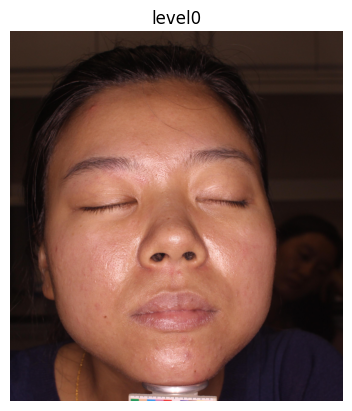

In [13]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(classes)) # get a random class name

## Transfer learning test

In [19]:
# Create datasets using image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 label_mode='categorical', # for multi-class classification
                                                                 shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                label_mode='categorical')

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply data augmentation and normalization to training data
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to test data
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance (overlap data preprocessing and model execution)
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


Found 1090 files belonging to 4 classes.
Found 367 files belonging to 4 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Transfer learning: use pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent training
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps to a single vector
    Dropout(0.3),              # Add dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),              # Another dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 acne severity classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [22]:
# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 308s 7s/step - accuracy: 0.3589 - loss: 1.5438 - val_accuracy: 0.4823 - val_loss: 1.0135 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4534 - loss: 1.0931 - val_accuracy: 0.5559 - val_loss: 0.9542 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5083 - loss: 1.0353 - val_accuracy: 0.5477 - val_loss: 0.9224 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5085 - loss: 1.0048 - val_accuracy: 0.5695 - val_loss: 0.8721 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5049 - loss: 1.0193 - val_accuracy: 0.5777 - val_loss: 0.8613 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5086 - loss: 0.9836 - val_accuracy: 0.5940 - val_loss: 0.8955 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5160 - loss: 0.9840 - val_accuracy:

In [23]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 947ms/step - accuracy: 0.6531 - loss: 0.7668
Test accuracy: 0.63


## Normal training

In [15]:
# Create baseline model
model_baseline = Sequential([
    Input(shape=(224, 224, 3)),  # Define input shape using Input layer
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Increased dropout before output layer
    Dense(4, activation='softmax')  # 4 neurons for the 4 classes
])

# Compile the model with a learning rate scheduler
model_baseline.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 51, 51, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 296,420 (1.13 MB)

 Trainable params: 295,972 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 verbose=1,
                                 min_lr=1e-6)

# Optional: Set up a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

In [17]:
# Fit the model with callbacks
history = model_baseline.fit(train_data,
                         epochs=10,
                         validation_data=test_data,
                         callbacks=[lr_scheduler, checkpoint])

Epoch 1/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.3460 - loss: 1.4077

KeyboardInterrupt: 

In [ ]:
# Evaluate on the test data
model_baseline.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.4664 - loss: 1.2688


[1.2846068143844604, 0.4332424998283386]

## Plot results

### Normal training

In [24]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    # Extract loss and accuracy from the history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))  # Get the number of epochs

    # Plot loss
    plt.figure(figsize=(12, 5))  # Set figure size for better readability
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plots


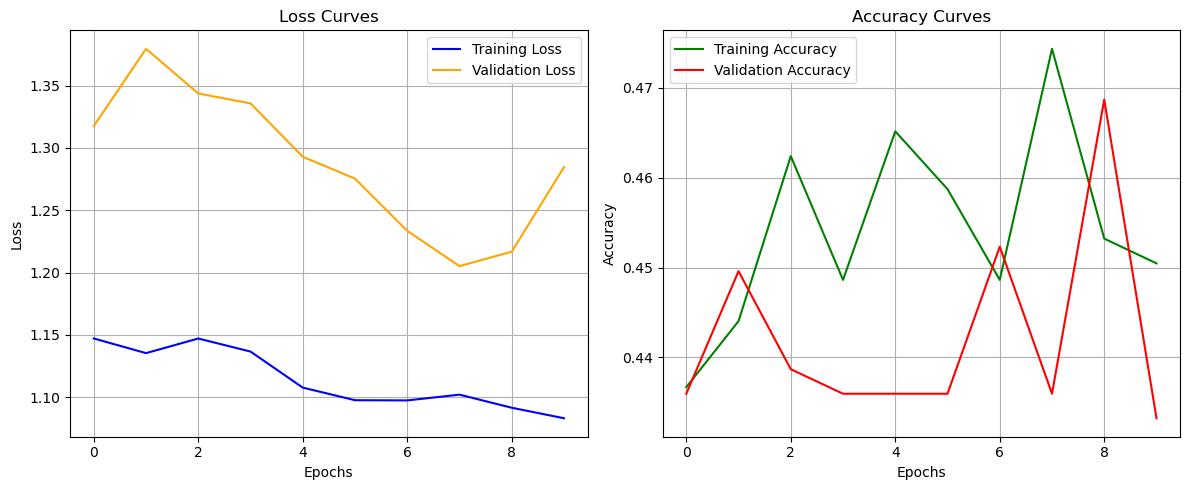

In [ ]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

### Transfer learning

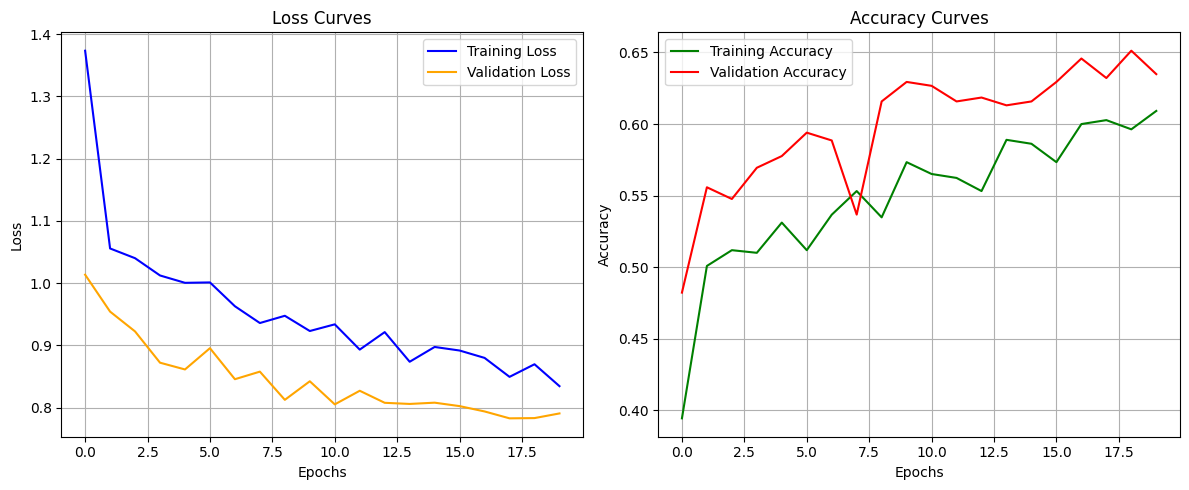

In [25]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

## Save model

In [27]:
# Save the entire model
model.save('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')  # Save the model as a .h5 file

In [ ]:
# Load the saved .keras model
from keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')



In [ ]:
# Evaluate the loaded model on test data
test_loss, test_acc = loaded_model.evaluate(test_data)
print(f"Loaded .keras model test accuracy: {test_acc:.2f}")

In [ ]:
loaded_model.summary()